In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pylab as plt
from datetime import datetime as dt_obj, timedelta
import drms
import matplotlib.dates as mdates
from tqdm import tqdm
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
import pandas as pd
pd.set_option('display.max_rows', None)

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

In [2]:
# import the final table of geomagnetic storms
path = '.'
filename = 'GSs_50nT.csv'
# filename = 'M-class-flares_SC24.csv'
# filename = 'X-class-flares_SC24.csv'
df_table = pd.read_csv(f'{path}/{filename}')

In [3]:
# show the names of columns
print(df_table.columns)

Index(['Year', 'month', 'day', 'time/UT', 'Dst', 'CME_onset', 'CME_speed',
       'CME_AW', 'MPA', 'old #', 'Flare_Year', 'Flare_Month', 'Flare_Day',
       'Flare_onset', 'Flare_peak', 'Flare_end', 'C-class', 'lat', 'long',
       'AR number', 'AR location', 'AR same day', 'AR next day', 'new #',
       'USFLUX-0', 'USFLUX-rise', 'USFLUX-all', 'USFLUS-dec', 'MEANGAM-0',
       'MEANGAM-rise', 'MEANGAM-all', 'MEANGAM-dec', 'MEANGBT-0',
       'MEANGBT-rise', 'MEANGBT-all', 'MEANGBT-dec', 'MEANGBZ-0',
       'MEANGBZ-rise', 'MEANGBZ-all', 'MEANGBZ-dec', 'MEANGBH-0',
       'MEANGBH-rise', 'MEANGBH-all', 'MEANGBH-dec', 'MEANJZD-0',
       'MEANJZD-rise', 'MEANJZD-all', 'MEANJZD-dec', 'TOTUSJZ-0',
       'TOTUSJZ-rise', 'TOTUSJZ-all', 'TOTUSJZ-dec', 'MEANALP-0',
       'MEANALP-rise', 'MEANALP-all', 'MEANALP-dec', 'MEANJZH-0\n',
       'MEANJZH-rise\n', 'MEANJZH-all', 'MEANJZH-dec', 'TOTUSJH-0',
       'TOTUSJH-rise', 'TOTUSJH-all', 'TOTUSJH-dec', 'ABSNJZH-0',
       'ABSNJZH-rise', 'ABSN

In [4]:
df_table.head()

,Year,month,day,time/UT,Dst,CME_onset,CME_speed,CME_AW,MPA,old #,...,TOTPOT-all,TOTPOT-dec,MEANSHR-0,MEANSHR-rise,MEANSHR-all,MEANSHR-dec,R_VALUE-0,R_VALUE-rise\n,R_VALUE-all,R_VALUE-dec
0,2010,8,4,2,-74,01/13:42,850,360,84,1,...,4.210000e+23,4.220000e+23,42.600,42.90000,43.100000,43.20000,3.660,3.62000,3.670000,3.70000
1,2011,3,11,6,-83,07/20:00u,2125,360,313,2,...,1.010000e+24,1.010000e+24,32.357,32.63600,32.876833,33.03600,4.816,4.81800,4.812167,4.80825
2,2011,8,6,4,-115,04/04:12,1315,360,298,3,...,4.380000e+23,4.430000e+23,39.166,38.85600,38.721500,38.58700,4.704,4.69400,4.690500,4.68700
3,2011,9,10,5,-75,06/23:06u,575,360,300,4,...,3.260000e+23,3.320000e+23,40.313,40.32900,40.346500,40.36400,4.292,4.29700,4.306000,4.31500
4,2011,9,26,24,-118,24/12:48,1915,360,78,5,...,1.840000e+24,1.850000e+24,44.522,44.72075,44.792250,44.86375,4.811,4.82725,4.839250,4.85125


In [5]:
if filename == 'GSs_50nT.csv':
    def create_datetime(row):
        """
        Make a datetime column from a row in a dataframe.
        """
        yyyy = int(row['Flare_Year'])
        mm = int(row['Flare_Month'])
        dd = int(row['Flare_Day'])
        flare_onset = row['Flare_onset']
        time = dt_obj.strptime(flare_onset, '%H:%M')
        return dt_obj(yyyy, mm, dd, time.hour, time.minute)

else:
    def create_datetime(row):
        """
        Make a datetime column from a row in a dataframe.
        """
        yyyy = int(row['year'])
        mm = int(row['month'])
        dd = int(row['day'])
        flare_onset = row['onset']
        time = dt_obj.strptime(flare_onset, '%H:%M')
        return dt_obj(yyyy, mm, dd, time.hour, time.minute)


def parse_tai_string(time_str, datetime_obj=True):
    """
    Convert the keyword `T_REC` into a datetime object.
    """
    year   = int(time_str[:4])
    month  = int(time_str[5:7])
    day    = int(time_str[8:10])
    hour   = int(time_str[11:13])
    minute = int(time_str[14:16])
    if datetime_obj:
        return dt_obj(year, month, day, hour, minute)
    else:
        return year, month, day, hour, minute

In [6]:
# add a datetime column for the flare onset time
df_table['datetime_flare_onset'] = df_table.apply(create_datetime, axis=1)

In [7]:
c = drms.Client()
c.series(r'hmi\.sharp_')

['hmi.sharp_720s',
 'hmi.sharp_720s_dconS',
 'hmi.sharp_720s_nrt',
 'hmi.sharp_cea_720s',
 'hmi.sharp_cea_720s_dconS',
 'hmi.sharp_cea_720s_nrt']

### Select which row (event) to work with

In [8]:
event_index = 25

flare_onset_datetime = df_table['datetime_flare_onset'][event_index]
flare_onset_date = str(flare_onset_datetime.date()).split('-')
flare_onset_time = str(flare_onset_datetime.time()).split(':')

end_year = flare_onset_date[0]
end_month = flare_onset_date[1]
end_day = flare_onset_date[2]

end_hour = flare_onset_time[0]
end_minute = flare_onset_time[1]

dt_window = 12 # +/- dt time in hours

start_datetime = flare_onset_datetime - timedelta(hours=dt_window)
start_date = str(start_datetime.date()).split('-')
start_time = str(start_datetime.time()).split(':')

start_year = start_date[0]
start_month = start_date[1]
start_day = start_date[2]

start_hour = start_time[0]
start_minute = start_time[1]

if filename == 'GSs_50nT.csv':
    noaa_ar =  df_table['AR number'][event_index]   # NOAA AR No. (i.e., 11092)
else:
    noaa_ar =  df_table['AR'][event_index]

# # Remove the last character (letter)
# if type(noaa_ar) == str:
#     if noaa_ar[-1].isalpha():
#         noaa_ar = noaa_ar[:-1]

data_type = 'hmi.sharp_cea_720s'

si = c.info(data_type) # Set a series

print(f'Start datetime: {start_datetime}')
print(f'Start year: {start_year}')
print(f'Start month: {start_month}')
print(f'Start day: {start_day}')
print(f'Start hour: {start_hour}')
print(f'Start minute: {start_minute}\n')

print(f'End datetime: {flare_onset_datetime}')
print(f'End year: {end_year}')
print(f'End month: {end_month}')
print(f'End day: {end_day}')
print(f'End hour: {end_hour}')
print(f'End minute: {end_minute}\n')

print(f'NOAA AR No.: {noaa_ar}')
print(f'SHARP dataset: {data_type}')

Start datetime: 2013-03-23 00:15:00
Start year: 2013
Start month: 03
Start day: 23
Start hour: 00
Start minute: 15

End datetime: 2013-03-23 12:15:00
End year: 2013
End month: 03
End day: 23
End hour: 12
End minute: 15

NOAA AR No.: 11704
SHARP dataset: hmi.sharp_cea_720s


In [10]:
# # Find more information about the FITS header keywords that belong to any given series
# si.keywords

In [11]:
# # See all the segments associated with the series
# si.segments

In [9]:
sharp_starttime = pd.to_datetime(f'{start_year}.{start_month}.{start_day} {start_hour}:{start_minute}')
# add a time offset to get full SHARP timeseries data that covers the flare end time
sharp_endtime   = pd.to_datetime(f'{end_year}.{end_month}.{end_day} {end_hour}:{end_minute}') + timedelta(hours=2)

print(f'SHARP start time: {sharp_starttime}')
print(f'SHARP end time: {sharp_endtime}')

keys = c.query(f'{data_type}[][{sharp_starttime} - {sharp_endtime}][? NOAA_ARS ~ "{noaa_ar}" ?]',
                      key='T_REC, HARPNUM, NOAA_ARS, USFLUX, MEANGAM, MEANGBT, MEANGBZ, MEANGBH, MEANJZD, TOTUSJZ,\
                        MEANALP, MEANJZH, TOTUSJH, ABSNJZH, SAVNCPP, MEANPOT, TOTPOT, MEANSHR, R_VALUE')
if len(keys) == 0:
    print('No SHARP data found!')
else:
    print(f'SHARP data found! --> length: {len(keys)}')

SHARP start time: 2013-03-23 00:15:00
SHARP end time: 2013-03-23 14:15:00
SHARP data found! --> length: 63


In [173]:
# run a for loop to identify the events indicies that have SHARP data available
event_indices_with_sharp_data    = []
event_indices_without_sharp_data = []

with tqdm(total=len(df_table), desc=f'Loading events info ...') as pbar:
    for event_index in range(len(df_table)):
        flare_onset_datetime = df_table['datetime_flare_onset'][event_index]
        flare_onset_date = str(flare_onset_datetime.date()).split('-')
        flare_onset_time = str(flare_onset_datetime.time()).split(':')

        end_year = flare_onset_date[0]
        end_month = flare_onset_date[1]
        end_day = flare_onset_date[2]

        end_hour = flare_onset_time[0]
        end_minute = flare_onset_time[1]

        dt_window = 12 # +/- dt time in hours

        start_datetime = flare_onset_datetime - timedelta(hours=dt_window)
        start_date = str(start_datetime.date()).split('-')
        start_time = str(start_datetime.time()).split(':')

        start_year = start_date[0]
        start_month = start_date[1]
        start_day = start_date[2]

        start_hour = start_time[0]
        start_minute = start_time[1]
        
        if filename == 'GSs_50nT.csv':
            noaa_ar =  df_table['AR number'][event_index]   # NOAA AR No. (i.e., 11092)
        else:
            noaa_ar =  df_table['AR'][event_index]
        
        # Remove the last character (letter)
        if noaa_ar[-1].isalpha():
            noaa_ar = noaa_ar[:-1]
        
        si = c.info(data_type) # Set a series

        sharp_starttime = pd.to_datetime(f'{start_year}.{start_month}.{start_day} {start_hour}:{start_minute}')
        # add a time offset to get full SHARP timeseries data that covers the flare end time
        sharp_endtime   = pd.to_datetime(f'{end_year}.{end_month}.{end_day} {end_hour}:{end_minute}') + timedelta(hours=2)

        keys = c.query(f'{data_type}[][{sharp_starttime} - {sharp_endtime}][? NOAA_ARS ~ "{noaa_ar}" ?]',
                            key='T_REC, HARPNUM, NOAA_ARS, USFLUX, MEANGAM, MEANGBT, MEANGBZ, MEANGBH, MEANJZD, TOTUSJZ, MEANALP,\
                                MEANJZH, TOTUSJH, ABSNJZH, SAVNCPP, MEANPOT, TOTPOT, MEANSHR, R_VALUE')
        if len(keys) == 0:
            # print(f'No SHARP data found for event index --> {event_index}')
            event_indices_without_sharp_data.append(event_index)
            pass
        else:
            # print(f'SHARP data found! --> {event_index} length: {len(keys)}')
            event_indices_with_sharp_data.append(event_index)
        pbar.update(1)

Loading events info ...: 100%|██████████| 64/64 [01:22<00:00,  1.29s/it]


In [174]:
print(len(df_table))
print(len(event_indices_without_sharp_data))
print(len(event_indices_with_sharp_data))

64
5
59


In [ ]:
event_indices_without_sharp_data

[25, 30, 43, 59, 61, 62, 63]

In [71]:
display(keys['T_REC'].head(3))
display(keys['T_REC'].tail(3))

0    2011.09.06_10:12:00_TAI
1    2011.09.06_10:24:00_TAI
2    2011.09.06_10:36:00_TAI
Name: T_REC, dtype: object

68    2011.09.06_23:48:00_TAI
69    2011.09.07_00:00:00_TAI
70    2011.09.07_00:12:00_TAI
Name: T_REC, dtype: object

In [10]:
t_rec = np.array([parse_tai_string(keys.T_REC[i], datetime_obj=True) for i in range(keys.T_REC.size)])

In [11]:
# Show a sample for validation purposes
print(f'First few samples:\n{t_rec[:3]}')
print(f'Last few samples:\n{t_rec[-3:]}')

First few samples:
[datetime.datetime(2013, 3, 23, 0, 12)
 datetime.datetime(2013, 3, 23, 0, 24)
 datetime.datetime(2013, 3, 23, 0, 36)]
Last few samples:
[datetime.datetime(2013, 3, 23, 13, 48)
 datetime.datetime(2013, 3, 23, 14, 0)
 datetime.datetime(2013, 3, 23, 14, 12)]


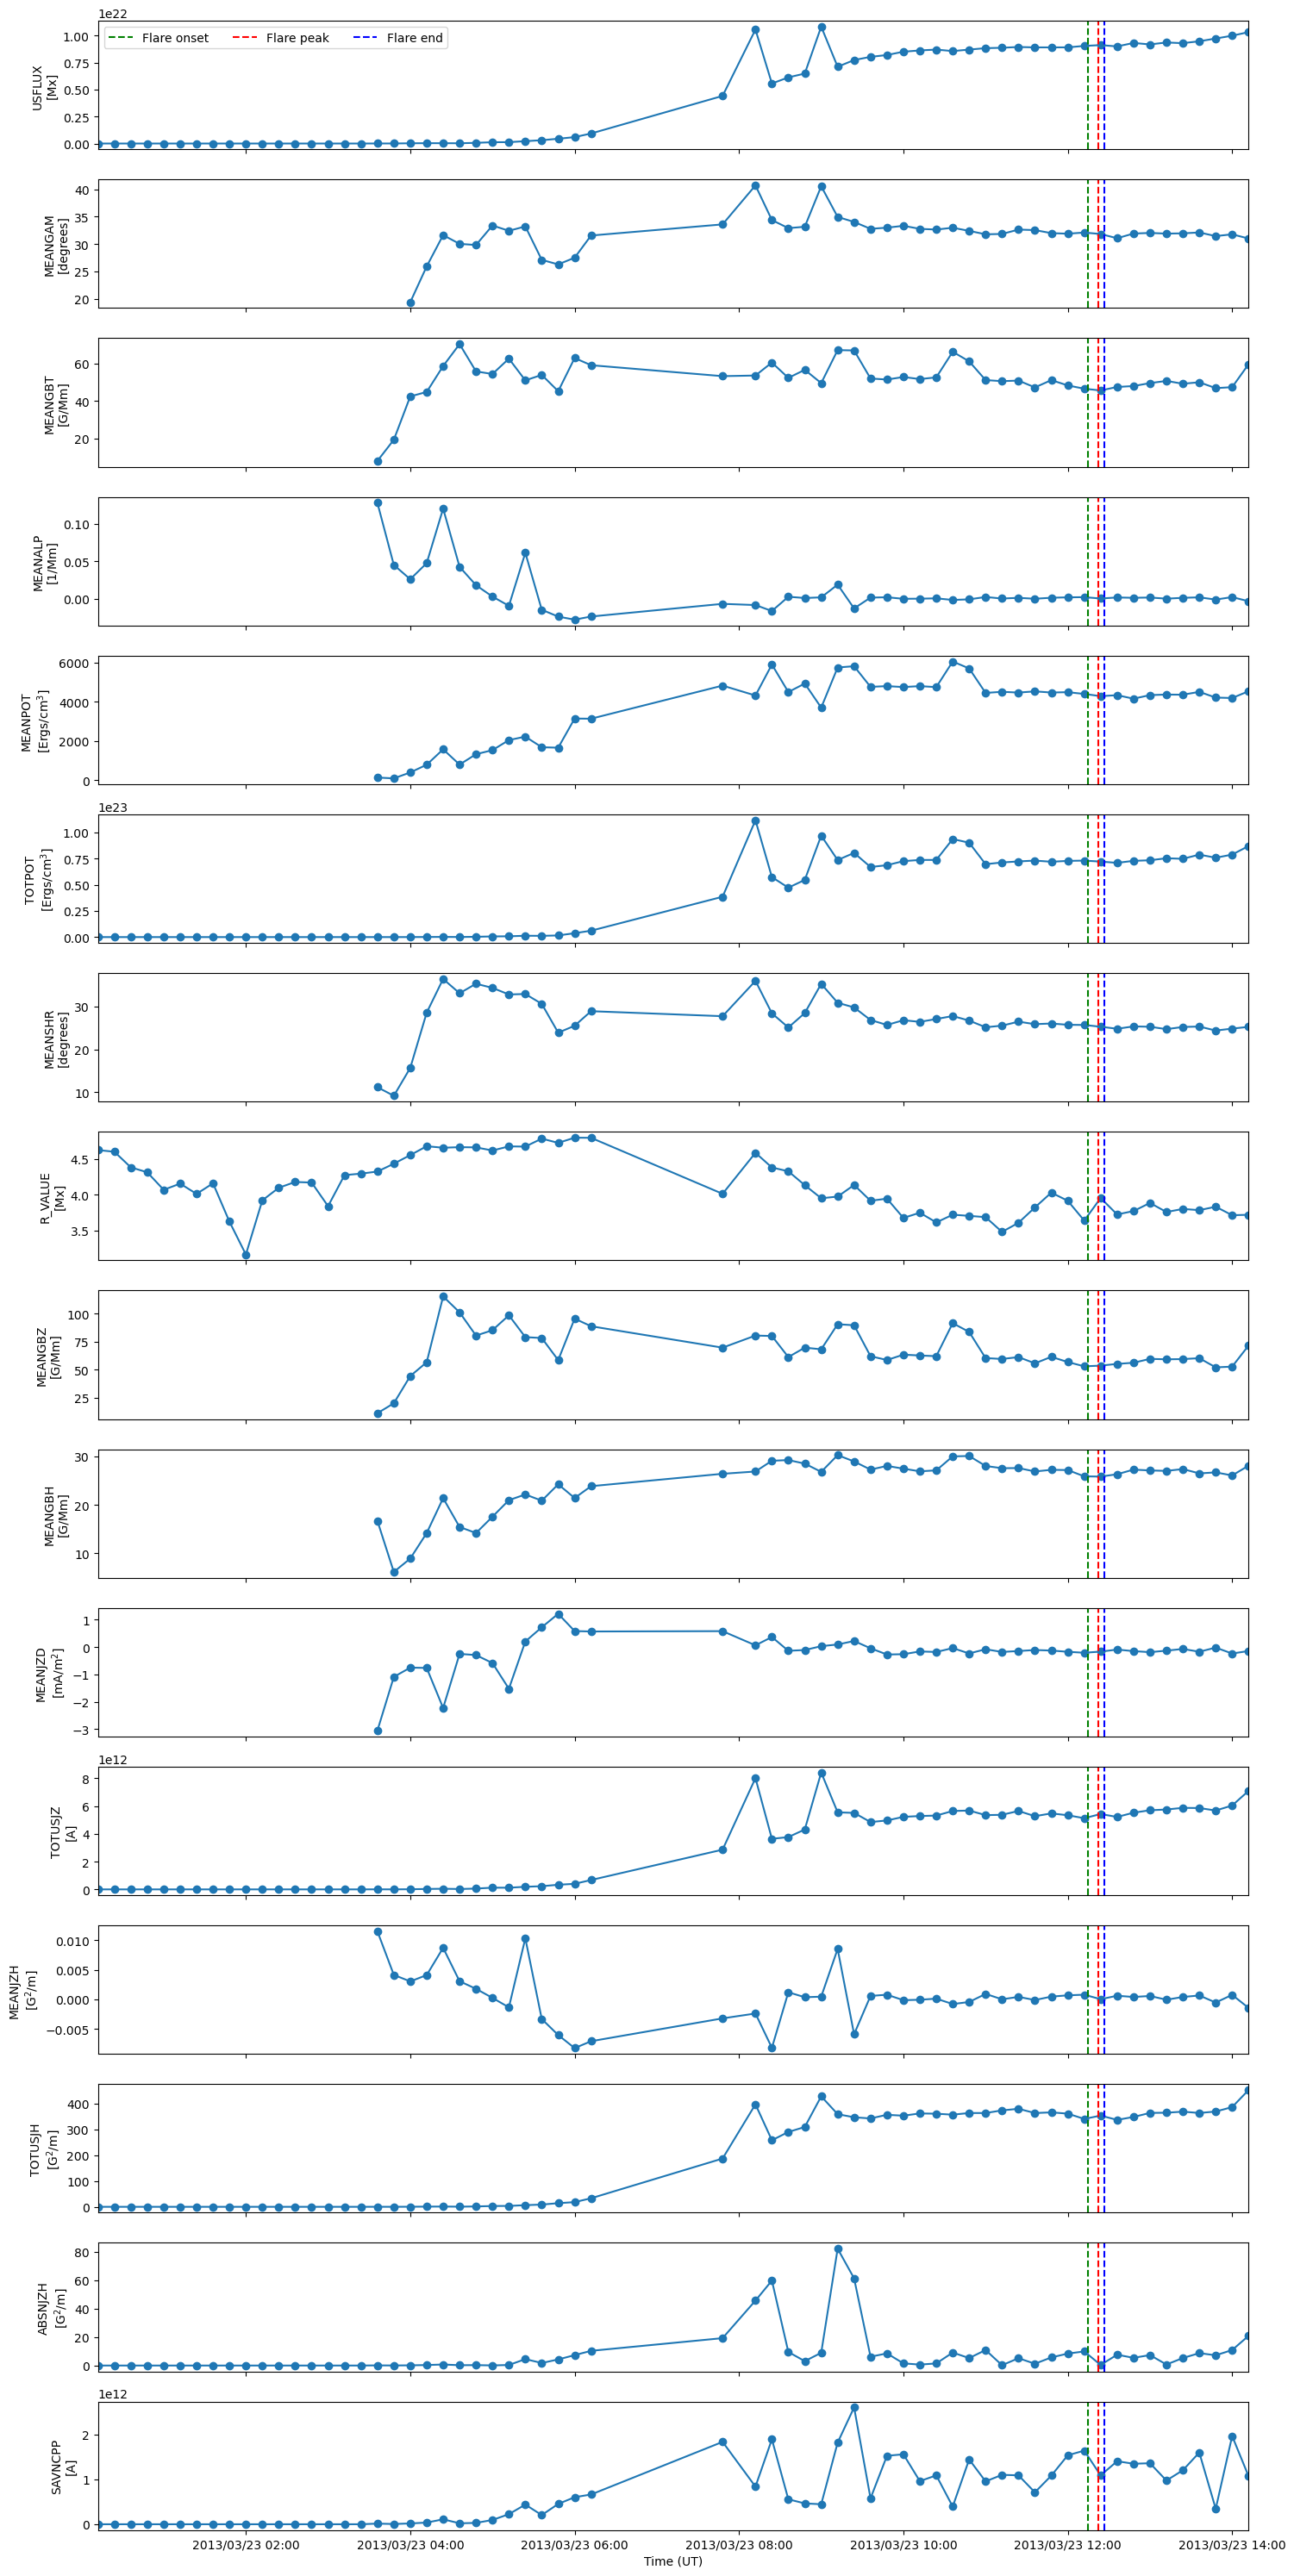

In [12]:
# Plot the choosen SHARP parameters in a for loop
chosen_parameters = {
    'USFLUX': 'USFLUX\n[Mx]',
    'MEANGAM': 'MEANGAM\n[degrees]',
    'MEANGBT': 'MEANGBT\n[G/Mm]',
    'MEANALP': 'MEANALP\n[1/Mm]',
    'MEANPOT': 'MEANPOT\n[Ergs/cm$^3$]',
    'TOTPOT': 'TOTPOT\n[Ergs/cm$^3$]',
    'MEANSHR': 'MEANSHR\n[degrees]',
    'R_VALUE': 'R_VALUE\n[Mx]',
    'MEANGBZ': 'MEANGBZ\n[G/Mm]',
    'MEANGBH': 'MEANGBH\n[G/Mm]',
    'MEANJZD': 'MEANJZD\n[mA/m$^2$]',
    'TOTUSJZ': 'TOTUSJZ\n[A]',
    'MEANJZH': 'MEANJZH\n[G$^2$/m]',
    'TOTUSJH': 'TOTUSJH\n[G$^2$/m]',
    'ABSNJZH': 'ABSNJZH\n[G$^2$/m]',
    'SAVNCPP': 'SAVNCPP\n[A]'
}

flare_peak_moment = pd.to_datetime(f"{flare_onset_datetime.date()} {df_table['Flare_peak'][event_index]}")
flare_end_moment = pd.to_datetime(f"{flare_onset_datetime.date()} {df_table['Flare_end'][event_index]}")

fig = plt.figure(figsize=[15,30])

for i, (col, unit) in enumerate(chosen_parameters.items()):
    ax = fig.add_subplot(len(chosen_parameters), 1, i+1)
    ax.plot(t_rec, keys[col], 'o-')
    ax.axvline(x=flare_onset_datetime, color='g', linestyle='--', label='Flare onset')
    ax.axvline(x=flare_peak_moment, color='r', linestyle='--', label='Flare peak')
    ax.axvline(x=flare_end_moment, color='b', linestyle='--', label='Flare end')
    ax.set_ylabel(unit)
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d %H:%M'))
    ax.set_xlim(left=t_rec[0], right=t_rec[-1])
    
    if i == 0:
        ax.legend(loc='best', ncol=3)
        ax.set_xticklabels([])
    elif i != len(chosen_parameters) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Time (UT)')

fig.tight_layout()
plt.show()

In [75]:
# fig.savefig('./20100801.pdf', format='pdf', bbox_inches='tight')

Prepare the coorelation tables

In [76]:
# === MAKE THESE TABLES AND EXPORT THEM ===
# corr_matrix_0    : first point (of each SHARP parameter) before the flare onset time.
# corr_matrix_rise : avg value (of each SHARP parameter) from the flare onset to peak time.
# corr_matrix_dec  : avg value (of each SHARP parameter) from the flare peak to end time.
# corr_matrix_all  : avg value (of each SHARP parameter) from the flare onset to end time.

In [13]:
# set the keys datetime as the index column
keys['datetimes'] = t_rec
try:
    keys.drop('T_REC', axis=1, inplace=True)
except:
    pass
keys.index = keys['datetimes']

display(keys.head(3))

,HARPNUM,NOAA_ARS,USFLUX,MEANGAM,MEANGBT,MEANGBZ,MEANGBH,MEANJZD,TOTUSJZ,MEANALP,MEANJZH,TOTUSJH,ABSNJZH,SAVNCPP,MEANPOT,TOTPOT,MEANSHR,R_VALUE,datetimes
datetimes,,,,,,,,,,,,,,,,,,,
2013-03-23 00:12:00,2587,11704,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,4.625,2013-03-23 00:12:00
2013-03-23 00:24:00,2587,11704,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,4.602,2013-03-23 00:24:00
2013-03-23 00:36:00,2587,11704,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,NaN,0.0,NaN,4.383,2013-03-23 00:36:00


In [14]:
# take only these columns from the given table of events
df = df_table.filter(['datetime_flare_onset', 'Dst', 'CME_onset', 'CME_speed',
                    'CME_AW', 'MPA', 'Flare_peak', 'Flare_end', 'C-class', 'lat', 'long',
                    'AR number', 'AR location', 'AR same day', 'AR next day'])
# df.set_index('datetime_flare_onset', drop=True)
df.index = df['datetime_flare_onset']
df.drop('datetime_flare_onset', axis=1, inplace=True)
display(df.head(3))

,Dst,CME_onset,CME_speed,CME_AW,MPA,Flare_peak,Flare_end,C-class,lat,long,AR number,AR location,AR same day,AR next day
datetime_flare_onset,,,,,,,,,,,,,,
2010-08-01 07:55:00,-74,01/13:42,850,360,84,8:26,9:35,3.2,20,-36,11092,N13E35,Alpha,Alpha
2011-03-07 19:43:00,-83,07/20:00u,2125,360,313,20:12,20:58,37.0,31,53,11164,N24W46,Beta-Gamma-Delta,Beta-Gamma-Delta
2011-08-04 03:41:00,-115,04/04:12,1315,360,298,3:57,4:04,93.0,19,36,11261,N16W37,Beta-Gamma,Beta-Gamma-Delta


### Get the first point (of each SHARP parameter) before the flare onset time ( `corr_matrix_0` )

In [15]:
# Get the index position of the flare_onset_datetime

# Check if the timestamp exists directly in the index
if flare_onset_datetime in keys.index:
    # Exact match found, get the position
    position = keys.index.get_loc(flare_onset_datetime)
    # Get the previous row if position is greater than 0, to avoid IndexError
    if position > 0:
        previous_row = keys.iloc[position - 1]
    else:
        previous_row = None  # Handle if it's the first row
else:
    # Use get_indexer to find the nearest timestamp before or equal to the target
    position = keys.index.get_indexer([flare_onset_datetime], method='pad')[0]
    # Check if the position is valid (it returns -1 if there’s no preceding match)
    if position != -1:
        # If a preceding timestamp is found, position will be non-negative
        if position > 0:
            previous_row = keys.iloc[position]
        else:
            previous_row = None  # It's the first row
    else:
        previous_row = None  # No timestamp before or equal to flare_onset_datetime

# display(previous_row)

# Combine the two rows from the two Dataframes
series1        = df.loc[flare_onset_datetime]
series2_0      = previous_row
combined_row_0 = pd.concat([series1, series2_0])

# Add the combined row to the final DataFrame
df_final_0 = pd.DataFrame(columns=combined_row_0.index)
df_final_0.loc[0] = combined_row_0

# export the dataframe


display(df_final_0)

,Dst,CME_onset,CME_speed,CME_AW,MPA,Flare_peak,Flare_end,C-class,lat,long,...,MEANALP,MEANJZH,TOTUSJH,ABSNJZH,SAVNCPP,MEANPOT,TOTPOT,MEANSHR,R_VALUE,datetimes
0,-59,23/12:24u,663,177,211,12:22,12:27,0.68,17u,-87u,...,0.0019,0.000793,340.031,9.914,1640674000000.0,4401.717,73065090000000003342336.0,25.673,3.637,2013-03-23 12:12:00


In [16]:
for event_index in range(len(df_table))[:3]:
    print(event_index)

0
1
2


### Get the average value (of each SHARP parameter) from the flare onset to peak time ( `corr_matrix_rise` )

In [17]:
series2_rise = keys.loc[flare_onset_datetime:flare_peak_moment].mean(skipna=True)

# Combine the two rows from the two Dataframes
combined_row_rise = pd.concat([series1, series2_rise])

# Add the combined row to the final DataFrame
df_final_rise = pd.DataFrame(columns=combined_row_rise.index)
df_final_rise.loc[0] = combined_row_rise

display(df_final_rise)

,Dst,CME_onset,CME_speed,CME_AW,MPA,Flare_peak,Flare_end,C-class,lat,long,...,MEANALP,MEANJZH,TOTUSJH,ABSNJZH,SAVNCPP,MEANPOT,TOTPOT,MEANSHR,R_VALUE,datetimes
0,-59,23/12:24u,663,177,211,12:22,12:27,0.68,17u,-87u,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


### Get the average value (of each SHARP parameter) from the flare peak to end time ( `corr_matrix_dec` )

In [18]:
series2_dec = keys.loc[flare_peak_moment:flare_end_moment].mean(skipna=True)

# Combine the two rows from the two Dataframes
combined_row_dec = pd.concat([series1, series2_dec])

# Add the combined row to the final DataFrame
df_final_dec = pd.DataFrame(columns=combined_row_dec.index)
df_final_dec.loc[0] = combined_row_dec

display(df_final_dec)

,Dst,CME_onset,CME_speed,CME_AW,MPA,Flare_peak,Flare_end,C-class,lat,long,...,MEANALP,MEANJZH,TOTUSJH,ABSNJZH,SAVNCPP,MEANPOT,TOTPOT,MEANSHR,R_VALUE,datetimes
0,-59,23/12:24u,663,177,211,12:22,12:27,0.68,17u,-87u,...,0.000079,0.000032,352.858,0.411,1089624000000.0,4288.938,72132889999999997313024.0,25.265,3.953,2013-03-23 12:24:00


### Get the average value (of each SHARP parameter) from the flare onset to end time ( `corr_matrix_all` )

In [19]:
series2_all = keys.loc[flare_onset_datetime:flare_end_moment].mean(skipna=True)

# Combine the two rows from the two Dataframes
combined_row_all = pd.concat([series1, series2_all])

# Add the combined row to the final DataFrame
df_final_all = pd.DataFrame(columns=combined_row_all.index)
df_final_all.loc[0] = combined_row_all

display(df_final_all)

,Dst,CME_onset,CME_speed,CME_AW,MPA,Flare_peak,Flare_end,C-class,lat,long,...,MEANALP,MEANJZH,TOTUSJH,ABSNJZH,SAVNCPP,MEANPOT,TOTPOT,MEANSHR,R_VALUE,datetimes
0,-59,23/12:24u,663,177,211,12:22,12:27,0.68,17u,-87u,...,0.000079,0.000032,352.858,0.411,1089624000000.0,4288.938,72132889999999997313024.0,25.265,3.953,2013-03-23 12:24:00


1. loop over all the events
2. calc the 4 corr dfs and export them
3. import them one by one for plotting

### Check the correlartions

In [20]:
# import the final table

filename = 'corr_matrix_0'
# filename = 'corr_matrix_all'
# filename = 'corr_matrix_dec'
# filename = 'corr_matrix_rise'

# filename = 'corr_matrix_cer' ... ?

# Load the data
df = pd.read_csv(f'{path}/{filename}.csv')
df.head()

,Unnamed: 0,Dst,CME_onset,CME_speed,CME_AW,MPA,Flare_peak,Flare_end,C-class,lat,...,MEANALP,MEANJZH,TOTUSJH,ABSNJZH,SAVNCPP,MEANPOT,TOTPOT,MEANSHR,R_VALUE,datetimes
0,0,-74,01/13:42,850,360,84,8:26,9:35,3.2,20,...,-0.014494,-0.007585,866.199,175.719,5.637476e+12,13645.760,4.198365e+23,42.629,3.659,2010-08-01 07:48:00
1,1,-83,07/20:00u,2125,360,313,20:12,20:58,37.0,31,...,0.010848,0.005078,4026.154,455.828,2.469219e+13,8322.466,9.921369e+23,32.357,4.816,2011-03-07 19:36:00
2,2,-115,04/04:12,1315,360,298,3:57,4:04,93.0,19,...,0.048845,0.019993,2696.795,745.497,3.030290e+13,8596.312,4.257019e+23,38.658,4.706,2011-08-04 03:36:00


In [96]:
df.columns

Index(['Unnamed: 0', 'Dst', 'CME_onset', 'CME_speed', 'CME_AW', 'MPA',
       'Flare_peak', 'Flare_end', 'C-class', 'lat', 'long', 'AR number',
       'AR location', 'AR same day', 'AR next day', 'HARPNUM', 'NOAA_ARS',
       'USFLUX', 'MEANGAM', 'MEANGBT', 'MEANGBZ', 'MEANGBH', 'MEANJZD',
       'TOTUSJZ', 'MEANALP', 'MEANJZH', 'TOTUSJH', 'ABSNJZH', 'SAVNCPP',
       'MEANPOT', 'TOTPOT', 'MEANSHR', 'R_VALUE', 'datetimes'],
      dtype='object')

In [98]:
# Drop unnecessary columns
df.drop(['Unnamed: 0','NOAA_ARS','lat','long','AR number','AR location','AR same day','AR next day','datetimes','CME_onset','Flare_peak','Flare_end'], axis=1, inplace=True)

In [99]:
len(df), df.columns

(64,
 Index(['Dst', 'CME_speed', 'CME_AW', 'MPA', 'C-class', 'HARPNUM', 'USFLUX',
        'MEANGAM', 'MEANGBT', 'MEANGBZ', 'MEANGBH', 'MEANJZD', 'TOTUSJZ',
        'MEANALP', 'MEANJZH', 'TOTUSJH', 'ABSNJZH', 'SAVNCPP', 'MEANPOT',
        'TOTPOT', 'MEANSHR', 'R_VALUE'],
       dtype='object'))

In [ ]:
# param_type = '0'

# chosen_parameters = ['Dst', 'CME_speed', 'CME_AW', 'flare_rise', 'flare_duration',
#         'SF_class', f'USFLUX-{param_type}', f'MEANGAM-{param_type}', f'MEANGBT-{param_type}',
#         f'MEANGBZ-{param_type}', f'MEANGBH-{param_type}', f'MEANJZD-{param_type}', f'TOTUSJZ-{param_type}',
#         f'MEANALP-{param_type}', f'MEANJZH-{param_type}', f'TOTUSJH-{param_type}', f'ABSNJZH-{param_type}',
#         f'SAVNCPP-{param_type}', f'MEANPOT-{param_type}', f'TOTPOT-{param_type}', f'MEANSHR-{param_type}',
#         f'R_VALUE-{param_type}']

# df = df[chosen_parameters]
# df.head()

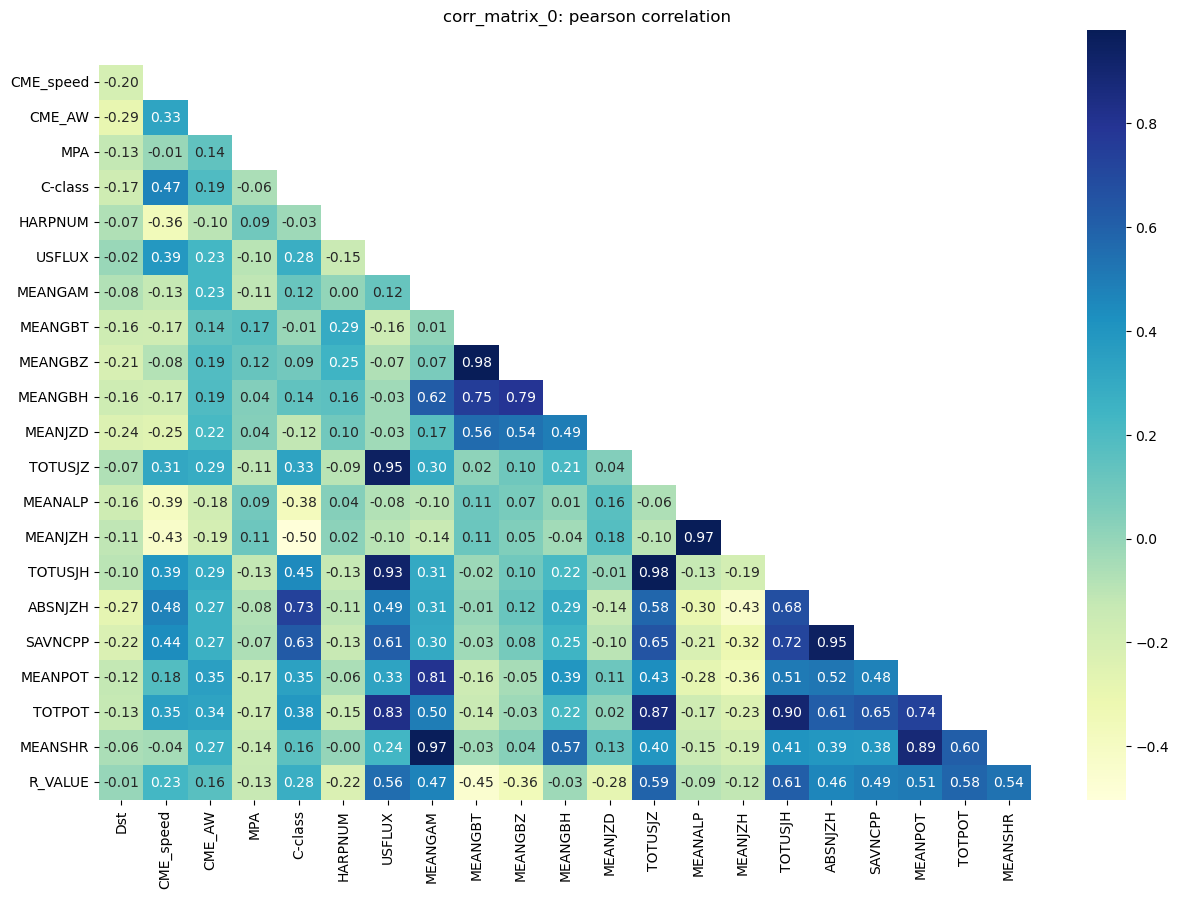

In [103]:
corr_method = 'pearson'

corr_matrix = df.corr(method=corr_method)

fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(111)

# Make a triangular mask
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
m = sns.heatmap(corr_matrix, annot=True, annot_kws={'size':10}, fmt='.2f', ax=ax, mask=mask, cmap='YlGnBu', cbar=True, cbar_kws={'pad':0.01})
m.set_title(f'{filename}: {corr_method} correlation')
m.set_xticks(m.get_xticks()[:-1])[:-1]
m.set_yticks(m.get_yticks()[1:])[1:]
# fig.savefig(f'./{filename}_{corr_method}.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [1]:
df

NameError: name 'df' is not defined

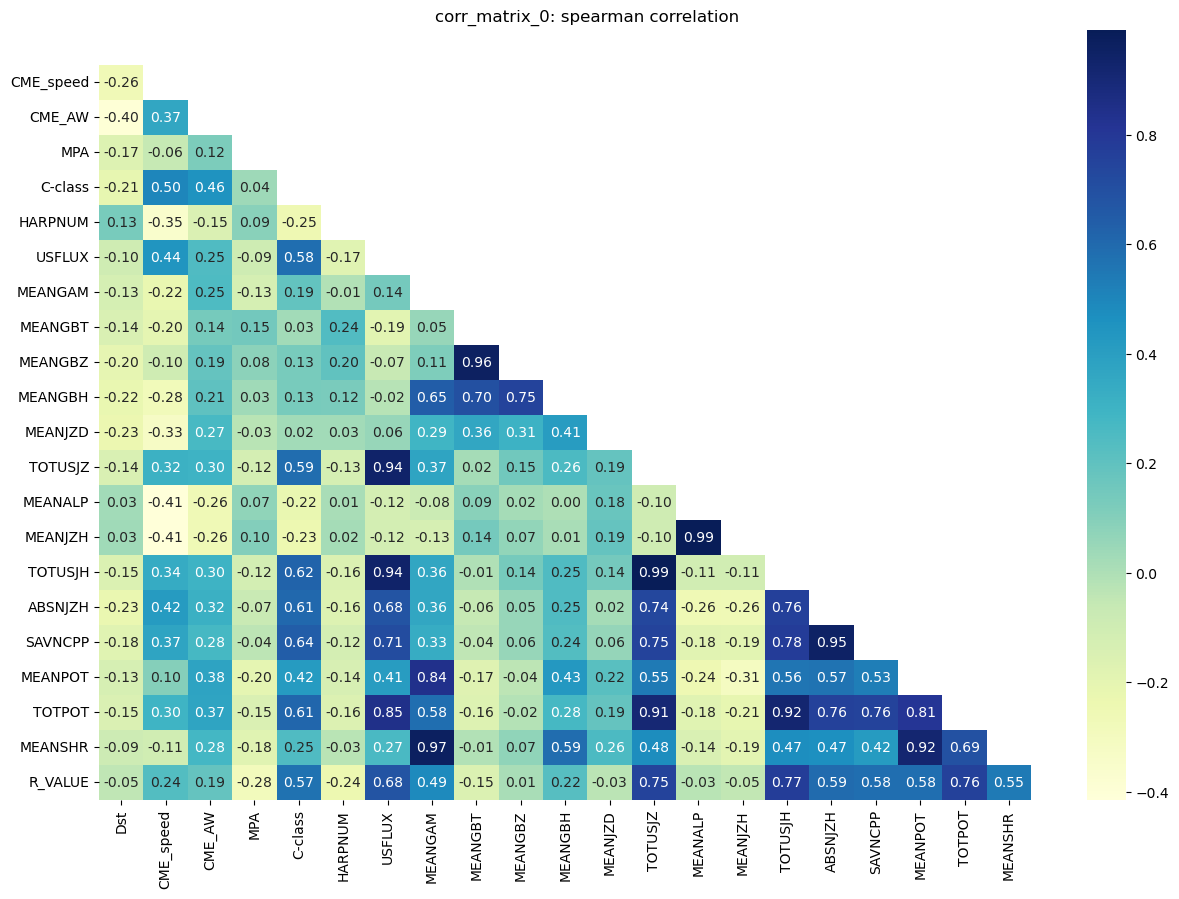

In [104]:
corr_method = 'spearman'

corr_matrix = df.corr(method=corr_method)

fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(111)

# Make a triangular mask
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
m = sns.heatmap(corr_matrix, annot=True, annot_kws={'size':10}, fmt='.2f', ax=ax, mask=mask, cmap='YlGnBu', cbar=True, cbar_kws={'pad':0.01})
m.set_title(f'{filename}: {corr_method} correlation')
m.set_xticks(m.get_xticks()[:-1])[:-1]
m.set_yticks(m.get_yticks()[1:])[1:]
# fig.savefig(f'./{filename}_{corr_method}.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
df.columns

In [ ]:
df.columns[6:-1]

In [ ]:
keys = df.columns[6:-1]
print(keys)

In [ ]:
df.dropna(axis=0, inplace=True)
df